## Data Analysis:
### analyze the data distribution:

Data shape: (10000, 5)

Class distribution:
label
0    0.9027
1    0.0973
Name: proportion, dtype: float64


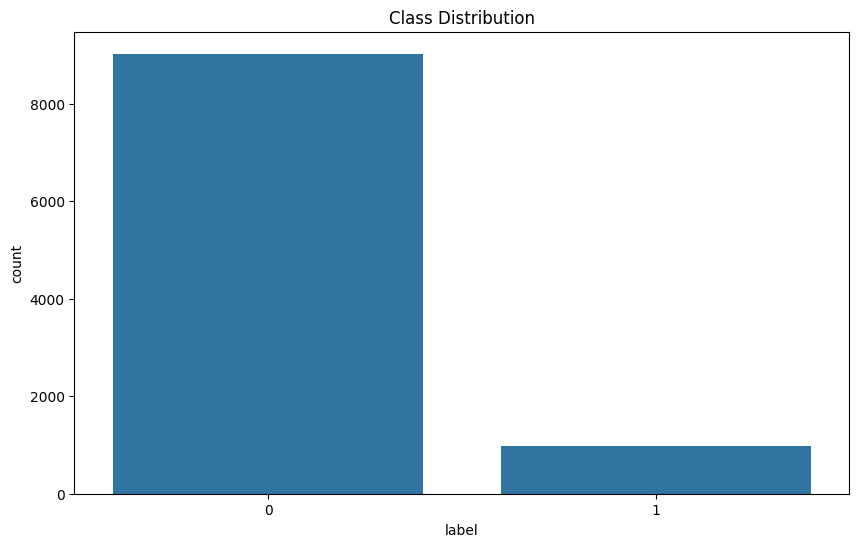

<Figure size 1200x800 with 0 Axes>

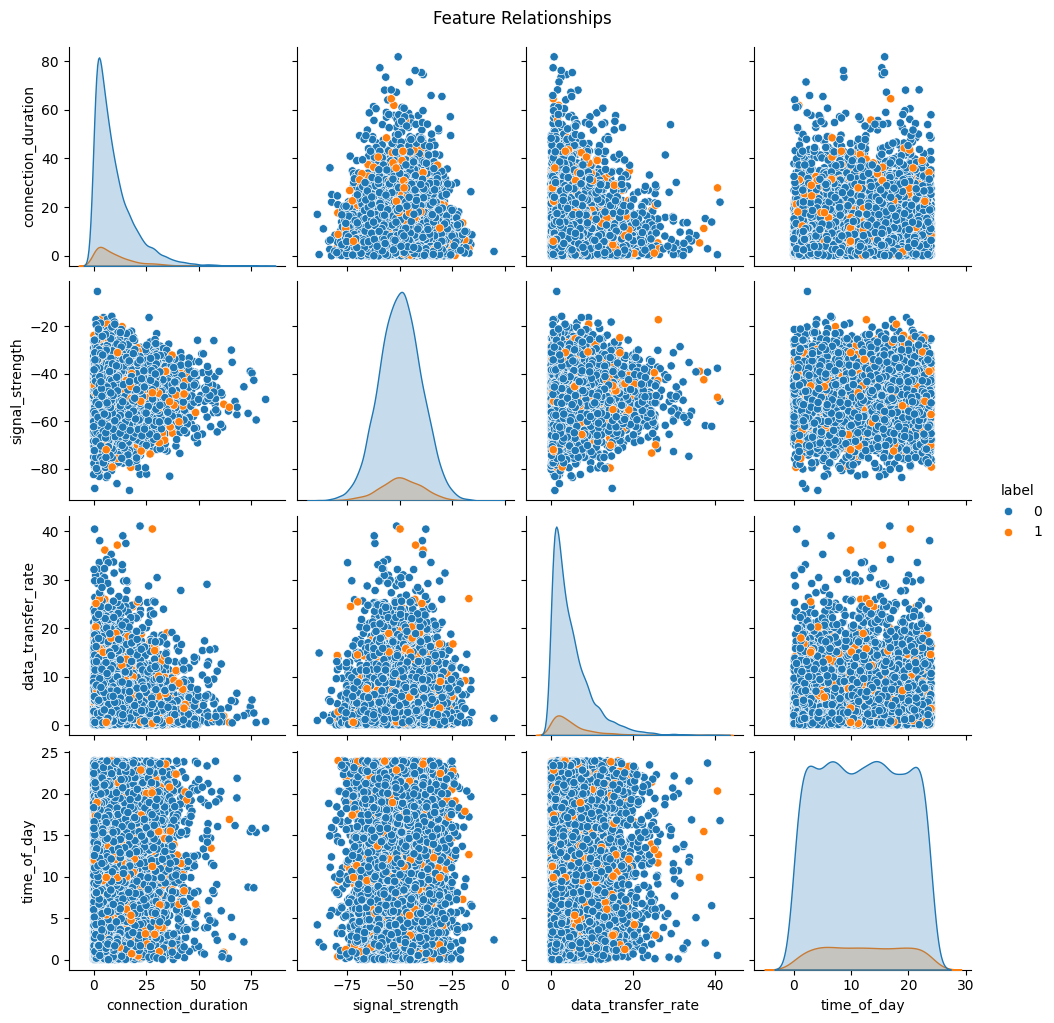

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_data(file_path):
    data = pd.read_csv(file_path)
    print("Data shape:", data.shape)
    print("\nClass distribution:")
    print(data['label'].value_counts(normalize=True))
    
    plt.figure(figsize=(10, 6))
    sns.countplot(x='label', data=data)
    plt.title('Class Distribution')
    plt.show()
    
    plt.figure(figsize=(12, 8))
    sns.pairplot(data, hue='label')
    plt.suptitle('Feature Relationships', y=1.02)
    plt.show()
    
    return data

data = analyze_data('bluetooth_data.csv')

## Data Preprocessing:
### Let's improve our preprocessing function

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

def preprocess_data(data):
    X = data.drop('label', axis=1)
    y = data['label']
    
    # Handle class imbalance using SMOTE
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_resampled)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test, scaler

X_train, X_test, y_train, y_test, scaler = preprocess_data(data)

## Model Selection and Training
### Multiple models and use cross-validation

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score

def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    models = {
        'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000),
        'Random Forest': RandomForestClassifier(class_weight='balanced', n_estimators=100),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100),
        'SVM': SVC(kernel='rbf', class_weight='balanced')
    }
    
    results = {}
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        cv_scores = cross_val_score(model, X_train, y_train, cv=5)
        
        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'cv_mean': cv_scores.mean()
        }
        
        print(f"\n{name} Results:")
        print(classification_report(y_test, y_pred))
        print(f"Cross-validation mean score: {cv_scores.mean():.4f}")
    
    return results

results = train_and_evaluate_models(X_train, X_test, y_train, y_test)


Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.51      0.49      0.50      1814
           1       0.51      0.53      0.52      1797

    accuracy                           0.51      3611
   macro avg       0.51      0.51      0.51      3611
weighted avg       0.51      0.51      0.51      3611

Cross-validation mean score: 0.5095

Random Forest Results:
              precision    recall  f1-score   support

           0       0.89      0.84      0.86      1814
           1       0.85      0.89      0.87      1797

    accuracy                           0.86      3611
   macro avg       0.87      0.86      0.86      3611
weighted avg       0.87      0.86      0.86      3611

Cross-validation mean score: 0.8453

Gradient Boosting Results:
              precision    recall  f1-score   support

           0       0.62      0.50      0.55      1814
           1       0.58      0.69      0.63      1797

    accuracy                

## Model Comparison
### Visualize the results

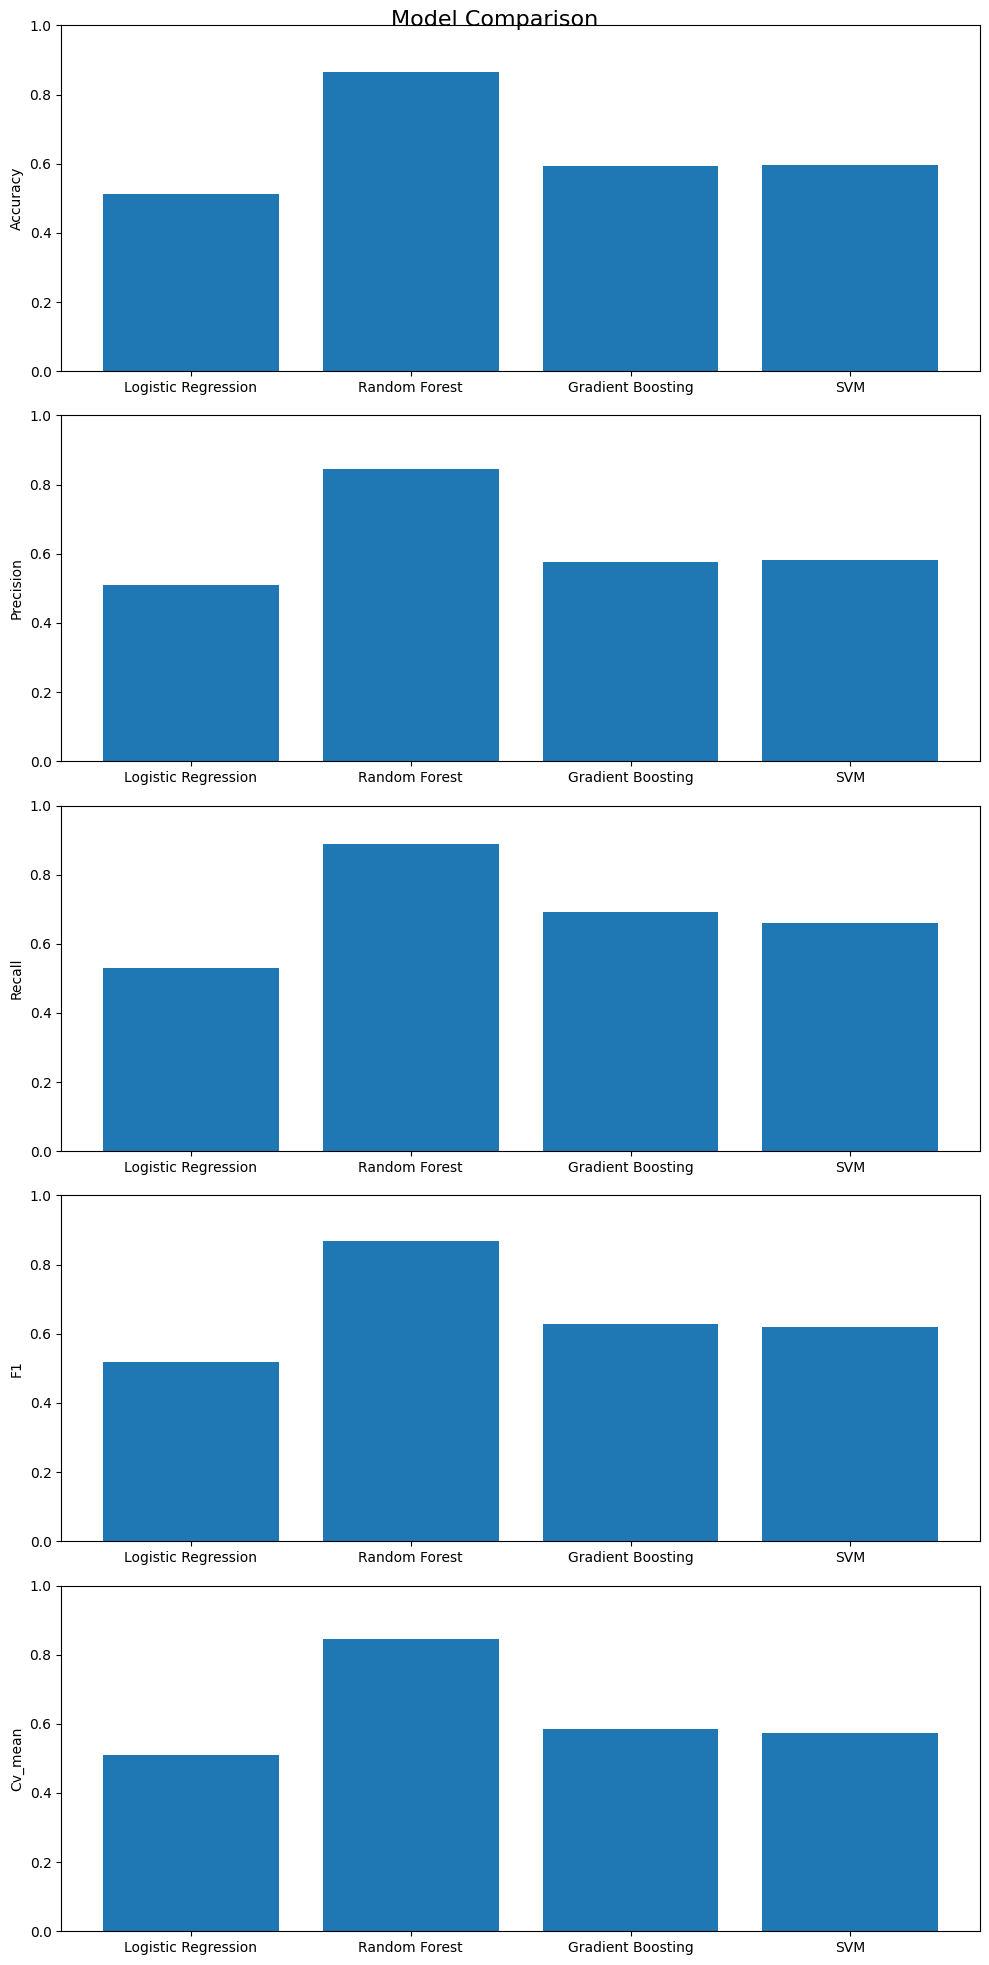

In [9]:
def plot_model_comparison(results):
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'cv_mean']
    
    fig, axes = plt.subplots(len(metrics), 1, figsize=(10, 4*len(metrics)))
    fig.suptitle('Model Comparison', fontsize=16)
    
    for i, metric in enumerate(metrics):
        values = [results[model][metric] for model in results]
        axes[i].bar(results.keys(), values)
        axes[i].set_ylabel(metric.capitalize())
        axes[i].set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()

plot_model_comparison(results)

## Hyperparameter Tuning
### Fine-tune the best performing model

In [10]:
from sklearn.model_selection import RandomizedSearchCV

def tune_best_model(best_model, X_train, y_train):
    if isinstance(best_model, RandomForestClassifier):
        param_dist = {
            'n_estimators': [100, 200, 300],
            'max_depth': [5, 10, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False]
        }
    elif isinstance(best_model, GradientBoostingClassifier):
        param_dist = {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 4, 5],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    else:
        return best_model  # No tuning for other models
    
    random_search = RandomizedSearchCV(best_model, param_distributions=param_dist, 
                                       n_iter=20, cv=5, random_state=42)
    random_search.fit(X_train, y_train)
    
    print("Best parameters:", random_search.best_params_)
    return random_search.best_estimator_

best_model_name = max(results, key=lambda x: results[x]['f1'])
best_model = results[best_model_name]['model']
tuned_model = tune_best_model(best_model, X_train, y_train)

# Evaluate the tuned model
y_pred = tuned_model.predict(X_test)
print("\nTuned Model Results:")
print(classification_report(y_test, y_pred))

Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': True}

Tuned Model Results:
              precision    recall  f1-score   support

           0       0.88      0.85      0.87      1814
           1       0.85      0.89      0.87      1797

    accuracy                           0.87      3611
   macro avg       0.87      0.87      0.87      3611
weighted avg       0.87      0.87      0.87      3611



## Feature Importance
### If the best model allows it, let's examine feature importance

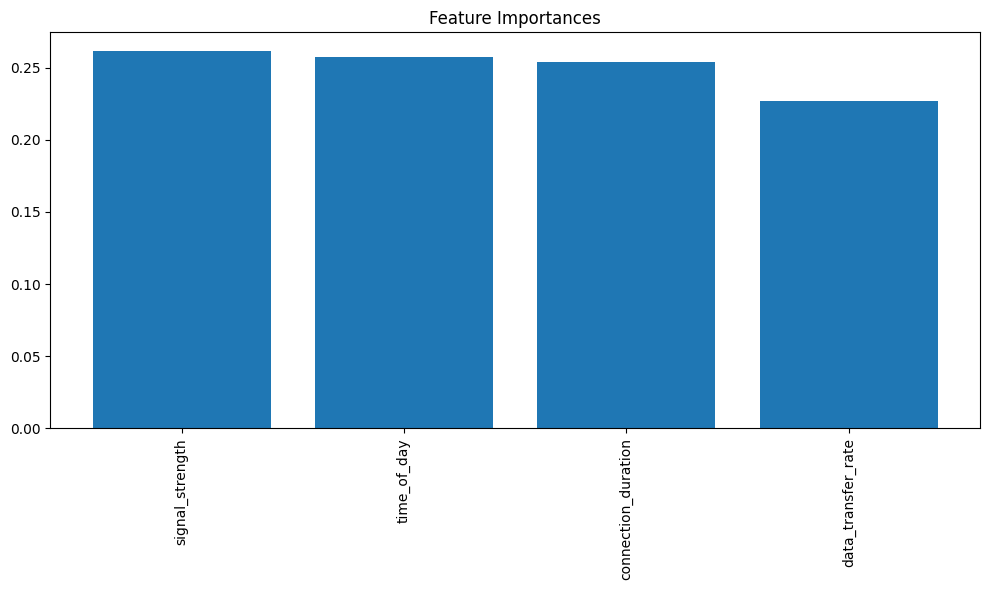

In [11]:
import numpy as np
def plot_feature_importance(model, feature_names):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        plt.figure(figsize=(10, 6))
        plt.title("Feature Importances")
        plt.bar(range(len(importances)), importances[indices])
        plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
        plt.tight_layout()
        plt.show()
    else:
        print("This model doesn't provide feature importances.")

plot_feature_importance(tuned_model, data.columns[:-1])

## Final Model Evaluation
### Let's evaluate the final model on a held-out test set

Final Model Evaluation:
              precision    recall  f1-score   support

           0       0.88      0.85      0.87      1814
           1       0.85      0.89      0.87      1797

    accuracy                           0.87      3611
   macro avg       0.87      0.87      0.87      3611
weighted avg       0.87      0.87      0.87      3611



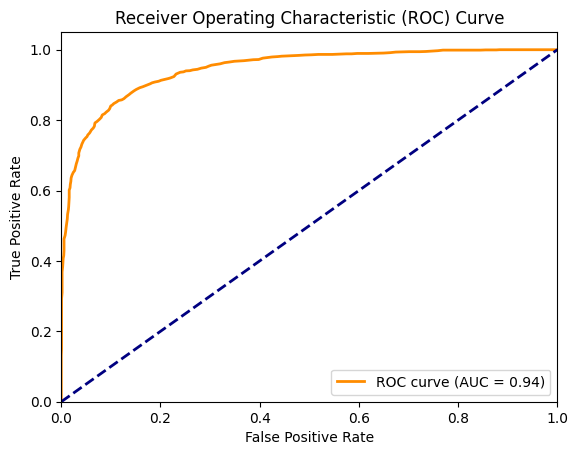

In [12]:
from sklearn.metrics import roc_curve, auc
def final_evaluation(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print("Final Model Evaluation:")
    print(classification_report(y_test, y_pred))
    
    # ROC Curve
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

final_evaluation(tuned_model, X_test, y_test)

## Save the Model
### For future use

In [13]:
import joblib

def save_model(model, scaler, feature_names, file_name):
    joblib.dump((model, scaler, feature_names), file_name)
    print(f"Model, scaler, and feature names saved to {file_name}")

def load_model(file_name):
    model, scaler, feature_names = joblib.load(file_name)
    return model, scaler, feature_names

# When saving:
feature_names = ['connection_duration', 'signal_strength', 'data_transfer_rate', 'time_of_day']
save_model(model, scaler, feature_names, 'bluetooth_anomaly_detector_new.joblib')

# When loading:
model, scaler, feature_names = load_model('bluetooth_anomaly_detector_new.joblib')

Model, scaler, and feature names saved to bluetooth_anomaly_detector_new.joblib


In [15]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import time
import random

# Load the saved model and scaler
model, scaler = joblib.load('bluetooth_anomaly_detector.joblib')

def generate_random_connection():
    features = ['connection_duration', 'signal_strength', 'data_transfer_rate', 'time_of_day']
    if np.random.random() < 0.1:  # 10% chance of anomaly
        return pd.DataFrame([np.random.rand(len(features)) * 2], columns=features)  # Anomalous data
    return pd.DataFrame([np.random.rand(len(features))], columns=features)  # Normal data

def display_connections():
    # Generate some random connections for demonstration
    normal = [generate_random_connection() for _ in range(10)]
    anomalous = [generate_random_connection() for _ in range(10)]
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter([x[0] for x in normal], [x[1] for x in normal], color='blue', label='Normal')
    plt.scatter([x[0] for x in anomalous], [x[1] for x in anomalous], color='red', label='Anomalous')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Bluetooth Connections')
    plt.legend()
    plt.show()

def simulate_realtime_detection(threshold=0.3):
    print(f"Simulating real-time detection with threshold {threshold}. Press Ctrl+C to stop.")
    try:
        while True:
            connection = generate_random_connection()
            scaled_connection = scaler.transform(connection)
            probability = model.predict_proba(scaled_connection)[0][1]
            
            if probability > threshold:
                print(f"ALERT: Potential unauthorized access detected! Confidence: {probability:.2f}")
                print("Simulating blocking of the connection...")
            else:
                print(f"Normal connection detected. Confidence: {1-probability:.2f}")
            
            time.sleep(2)
    except KeyboardInterrupt:
        print("\nSimulation stopped.")

def main_menu():
    while True:
        print("\nBluetooth Anomaly Detection System")
        print("1. Display Connections")
        print("2. Simulate Real-Time Detection")
        print("3. Exit")
        
        choice = input("Enter your choice (1-3): ")
        
        if choice == '1':
            display_connections()
        elif choice == '2':
            simulate_realtime_detection()
        elif choice == '3':
            print("Exiting the system. Goodbye!")
            break
        else:
            print("Invalid choice. Please try again.")

if __name__ == "__main__":
    model, scaler, feature_names = load_model('bluetooth_anomaly_detector_new.joblib')
    main_menu()


Bluetooth Anomaly Detection System
1. Display Connections
2. Simulate Real-Time Detection
3. Exit


KeyError: 0

<Figure size 1000x600 with 0 Axes>

In [19]:
import joblib
import pandas as pd
import numpy as np
import time
from sklearn.preprocessing import StandardScaler

def load_model(file_name):
    model, scaler, feature_names = joblib.load(file_name)
    return model, scaler, feature_names

def generate_random_connection(feature_names):
    if np.random.random() < 0.1:  # 10% chance of anomaly
        return pd.DataFrame([np.random.rand(len(feature_names)) * 2], columns=feature_names)  # Anomalous data
    return pd.DataFrame([np.random.rand(len(feature_names))], columns=feature_names)  # Normal data

def display_connections(feature_names):
    # Generate some random connections for demonstration
    normal = [generate_random_connection(feature_names) for _ in range(50)]
    anomalous = [generate_random_connection(feature_names) for _ in range(50)]
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter([x.iloc[0][0] for x in normal], [x.iloc[0][1] for x in normal], color='blue', label='Normal')
    plt.scatter([x.iloc[0][0] for x in anomalous], [x.iloc[0][1] for x in anomalous], color='red', label='Anomalous')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Bluetooth Connections')
    plt.legend()
    plt.show()
    
def simulate_realtime_detection(model, scaler, feature_names, threshold=0.3):
    print(f"Simulating real-time detection with threshold {threshold}. Press Ctrl+C to stop.")
    try:
        while True:
            connection = generate_random_connection(feature_names)
            scaled_connection = scaler.transform(connection)
            
            try:
                probability = model.predict_proba(scaled_connection)[0][1]
            except IndexError:
                print("Error: Unable to get prediction probability. Skipping this connection.")
                continue
            
            if probability > threshold:
                print(f"ALERT: Potential unauthorized access detected! Confidence: {probability:.2f}")
                print("Simulating blocking of the connection...")
            else:
                print(f"Normal connection detected. Confidence: {1-probability:.2f}")
            
            time.sleep(2)
    except KeyboardInterrupt:
        print("\nSimulation stopped.")

def main_menu():
    while True:
        print("\nBluetooth Anomaly Detection System")
        print("1. Simulate Real-Time Detection")
        print("2. Display Information")
        print("3. Exit")
        
        choice = input("Enter your choice (1-2): ")
        
        if choice == '1':
            simulate_realtime_detection(model, scaler, feature_names)
        elif choice == '2':
            display_connections(feature_names)
        elif choice == '3':
            print("Exiting the system. Goodbye!")
            break
        else:
            print("Invalid choice. Please try again.")

if __name__ == "__main__":
    try:
        model, scaler, feature_names = load_model('bluetooth_anomaly_detector_new.joblib')
        main_menu()
    except Exception as e:
        print(f"An error occurred while loading the model: {str(e)}")
        print("Please ensure that the model file exists and is not corrupted.")


Bluetooth Anomaly Detection System
1. Simulate Real-Time Detection
2. Display Information
3. Exit
An error occurred while loading the model: generate_random_connection() missing 1 required positional argument: 'feature_names'
Please ensure that the model file exists and is not corrupted.
